# 1. PROJE ÖDEVİ - BLG-407 MAKİNE ÖĞRENMESİ

**Adınız:** Mustafa Erdem

**Soyadınız:** Kaya

**Okul Numaranız:** 2212721009

**GitHub Repo Bağlantısı:** `https://github.com/kullanici_adi/CNN_siniflandirma`


# Model 1: VGG16 mimarisi ile kesici/delici ve taşıyıcı/servis eşyalarının sınıflandırılması

sınıflandırma için her sınıf için 100 görsel toplanmıştır. Kategoriler şunlardır:kesici/delici ve taşıyıcı/servis

veri setindeki her görüntü aynı boyuttadır 128x128



# Gerekli Kütüphanelerin İçe Aktarılması

Aşağıdaki blokta model eğitimi ve görselleştirme için gerekli kütüphaneler eklenmiştir:

* **`tensorflow`**: Derin öğrenme modeli oluşturmak ve eğitmek için ana kütüphane
* **`ImageDataGenerator`**: Görüntü verilerini ön işleme ve veri artırımı için
* **`VGG16`**: Önceden eğitilmiş VGG16 mimarisi (Transfer Learning için)
* **`layers, models`**: Sinir ağı katmanları ve model yapılarını oluşturmak için
* **`optimizers`**: Model optimizasyon algoritmaları için
* **`callbacks`**: Model eğitimi sırasında callback fonksiyonları (ModelCheckpoint gibi)
* **`matplotlib.pyplot`**: Grafik ve görselleştirme için
* **`sklearn.metrics`**: Model performans metrikleri (confusion matrix gibi)
* **`numpy`**: Sayısal işlemler için
* **`os`**: Dosya sistemi işlemleri için

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

#  Temel Ayarlar ve Sabitlerin Tanımlanması

Bu bölümde, model eğitimi boyunca kullanılacak temel yapılandırma ayarları ve sabitler tanımlanmaktadır.

* **Veri Seti Yolu (`dataset_path`):** Google Drive üzerinde bulunan veri setinin ana klasör yolu belirtilir.
* **Görüntü Boyutları (`IMG_HEIGHT`, `IMG_WIDTH`):** Modelin tutarlı öğrenmesi için tüm giriş görselleri **128x128** piksel boyutuna sabitlenir.
* **Batch Size (`BATCH_SIZE`):** Eğitim sırasında ağın ağırlıkları güncellenmeden önce aynı anda işlenecek örnek sayısı **32** olarak belirlenmiştir.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/makine öğrenmesi/ödev1/dataset'
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

Mounted at /content/drive


# Veri Hazırlığı ve VGG16 Model Kurulumu

Bu bölümde veriler işlenmekte ve Transfer Learning modeli oluşturulmaktadır.

### 1. Veri Ön İşleme (`ImageDataGenerator`)
* **Normalizasyon:** Piksel değerleri işlem kolaylığı için 0-1 aralığına getirildi (`rescale=1./255`). Bu, modelin daha hızlı ve stabil öğrenmesini sağlar.
* **Ayrım:** Veri seti **%80 Eğitim**, **%20 Doğrulama** olarak bölündü (`validation_split=0.2`). Bu oran, küçük veri setleri için uygun bir bölünme sağlar.
* **Mod:** İki sınıf olduğu için etiketleme **`binary`** modunda yapıldı. Bu mod, ikili sınıflandırma problemleri için optimize edilmiştir.

### 2. VGG16 Transfer Learning Stratejisi
**Neden VGG16?** VGG16, ImageNet veri setinde eğitilmiş, görüntü sınıflandırma için güçlü özellik çıkarıcı katmanlara sahip bir mimaridir. Bu özellik çıkarıcılar, genel görsel özellikleri (kenarlar, şekiller, dokular) öğrenmiştir ve yeni görevlere transfer edilebilir.

* **`weights='imagenet'`**: Model, ImageNet veri setinden öğrenilmiş hazır ağırlıklarla başlatıldı. Bu, sıfırdan eğitime göre çok daha hızlı ve etkili sonuçlar verir.
* **`include_top=False`**: Orijinal 1000 sınıflı çıkış katmanı atıldı. Kendi sınıflandırma katmanlarımızı ekleyeceğiz.
* **`trainable=False`**: VGG16'nın temel katmanları dondurularak mevcut ağırlıklar korundu. Bu strateji, önceden öğrenilmiş özellikleri korurken sadece yeni eklenen katmanları eğitir (Feature Extraction yaklaşımı).

### 3. Sınıflandırma Katmanları
* Modelin sonuna projeye özgü katmanlar eklendi.
* **Çıktı:** İkili sınıflandırma yapıldığı için **`Sigmoid`** aktivasyonu ve **`binary_crossentropy`** kayıp fonksiyonu kullanıldı. Sigmoid, çıktıyı 0-1 aralığına sıkıştırarak olasılık değeri üretir.

In [ ]:
# Veri ön işleme için ImageDataGenerator oluşturuluyor
datagen = ImageDataGenerator(
    rescale=1./255,          # Piksel değerlerini 0-1 aralığına normalize et
    validation_split=0.2     # Veri setinin %20'sini doğrulama için ayır
)

print("Eğitim verileri yükleniyor...")
# Eğitim verileri için generator oluşturuluyor
train_generator = datagen.flow_from_directory(
    dataset_path,                    # Veri setinin bulunduğu klasör
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Tüm görselleri 128x128 boyutuna getir
    batch_size=BATCH_SIZE,           # Her seferinde 32 görsel işle
    class_mode='binary',             # İkili sınıflandırma modu
    subset='training'                # Eğitim alt kümesini kullan (%80)
)

print("Doğrulama (Test) verileri yükleniyor...")
# Doğrulama verileri için generator oluşturuluyor
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'             # Doğrulama alt kümesini kullan (%20)
)

print(f"Algılanan sınıflar: {train_generator.class_indices}")



Eğitim verileri yükleniyor...
Found 160 images belonging to 2 classes.
Doğrulama (Test) verileri yükleniyor...
Found 40 images belonging to 2 classes.
Algılanan sınıflar: {'Kesici_Delici': 0, 'Taşıyıcı_Servis': 1}


# VGG16 Modelinin Tanımlanması

Bu kod bloğu, **Transfer Learning (Transfer Öğrenme)** tekniğini kullanarak, önceden eğitilmiş güçlü bir modelin (VGG16) üzerine kendi sınıflandırma katmanlarınızı inşa ettiğiniz bir yapıyı tanımlar.

## Transfer Learning Stratejisi: Feature Extraction

**Neden bu strateji?** Küçük veri setimiz (200 görsel) için sıfırdan eğitim yapmak yetersiz kalır. VGG16'nın ImageNet'te öğrendiği genel görsel özellikleri kullanarak, sadece son katmanları eğitmek hem daha hızlı hem de daha etkili sonuçlar verir.

## Model Mimarisi Açıklaması:

1. **VGG16 Base Model**: Milyonlarca resimle eğitilmiş VGG16 modelini, eğitilebilirliğini kapatarak (`trainable=False`) sadece görüntüden özellik (kenar, şekil, desen) çıkaran sabit bir "taban" olarak kullanıyoruz.

2. **Flatten Katmanı**: VGG16'dan çıkan çok boyutlu özellik haritasını tek boyutlu bir vektöre dönüştürür. Bu, yoğun (dense) katmanlara girdi sağlamak için gereklidir.

3. **Dense(256, activation='relu')**: 256 nöronlu tam bağlı katman. ReLU aktivasyonu ile özellikler arasındaki karmaşık ilişkileri öğrenir.

4. **Dropout(0.5)**: Nöronların %50'sini rastgele kapatarak modelin ezber yapmasını (overfitting) engeller. Bu, modelin genelleme yeteneğini artırır.

5. **Dense(1, activation='sigmoid')**: Çıkış katmanı. Sigmoid aktivasyonu ile 0-1 arasında bir olasılık değeri üretir (0: Kesici_Delici, 1: Taşıyıcı_Servis).

6. **Adam Optimizer**: Adaptif öğrenme oranına sahip, etkili bir optimizasyon algoritması.

7. **Binary Crossentropy Loss**: İkili sınıflandırma için uygun kayıp fonksiyonu.

In [ ]:
# VGG16 base modelini ImageNet ağırlıklarıyla yükle (Transfer Learning)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Base model katmanlarını dondur (sadece özellik çıkarıcı olarak kullan)

# Kendi sınıflandırma katmanlarımızı ekleyerek modeli oluştur
model = models.Sequential([
    base_model,                              # VGG16 özellik çıkarıcı (dondurulmuş)
    layers.Flatten(),                        # Çok boyutlu özellik haritasını düzleştir
    layers.Dense(256, activation='relu'),    # 256 nöronlu gizli katman (öğrenilebilir)
    layers.Dropout(0.5),                     # Overfitting'i önlemek için %50 dropout
    layers.Dense(1, activation='sigmoid')    # Çıkış katmanı (ikili sınıflandırma)
])

# Modeli derle: Adam optimizer ve binary crossentropy loss ile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()  # Model mimarisini görüntüle

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Model Eğitimi

Bu aşamada model eğitilmeye başlanır. Transfer Learning yaklaşımında, sadece eklediğimiz yeni katmanlar (Flatten, Dense, Dropout) eğitilirken, VGG16 base modeli dondurulmuş durumda kalır.

## ModelCheckpoint Kullanımı

Eğitim sırasında, her epoch'ta validation loss'u kontrol ederek en iyi performans gösteren model ağırlıklarını otomatik olarak kaydediyoruz. Bu sayede:
- Eğitim sırasında overfitting olsa bile en iyi modeli koruyoruz
- Model performansı düşse bile en iyi checkpoint'i geri yükleyebiliyoruz
- Zaman kaybetmeden en optimal modeli kullanabiliyoruz

## Eğitim Parametreleri:

* **`model.fit()`**: Eğitimi başlatan asıl fonksiyondur. Model bu aşamada verilerle ağırlıklarını günceller.

* **`train_generator`**: Modelin öğrenmek için kullanacağı eğitim verilerini sağlayan kaynaktır. Görselleri batch'ler halinde (32'şer) yükler.

* **`epochs=5`**: Modelin tüm eğitim veri setinin üzerinden 5 kez geçeceğini belirtir. Transfer Learning'de genellikle az epoch yeterlidir çünkü sadece son katmanlar eğitilir.

* **`validation_data=val_generator`**: Her bir epoch bittiğinde, modelin hiç görmediği bu doğrulama verileriyle test edilmesini sağlar. Bu sayede:
  - Modelin gerçekten öğrenip öğrenmediğini (ezberleyip ezberlemediğini) anlarız
  - Overfitting durumunu tespit ederiz
  - Model performansını izleriz

* **`callbacks=[checkpointer]`**: ModelCheckpoint callback'i, en iyi ağırlıkları otomatik olarak kaydeder.

**Not**: Eğitim sırasında `history` objesi, her epoch için accuracy ve loss değerlerini saklar. Bu değerler daha sonra grafik çizmek için kullanılacaktır.

In [ ]:
# ModelCheckpoint: En iyi ağırlıkları kaydet
checkpointer = ModelCheckpoint(
    filepath='model1_best_weights.weights.h5',
    monitor='val_loss',              # Validation loss'u izle
    verbose=1,                       # Kayıt işlemini göster
    save_best_only=True,            # Sadece en iyi modeli kaydet
    save_weights_only=True          # Sadece ağırlıkları kaydet (model yapısı değil)
)

print("Eğitim başlıyor...")
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpointer],       # En iyi ağırlıkları kaydetmek için callback
    verbose=1
)

Eğitim başlıyor...
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8975 - loss: 0.2487
Epoch 1: val_loss improved from inf to 0.20989, saving model to model1_best_weights.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.8969 - loss: 0.2520 - val_accuracy: 0.9000 - val_loss: 0.2099
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9356 - loss: 0.2112
Epoch 2: val_loss improved from 0.20989 to 0.12356, saving model to model1_best_weights.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.9370 - loss: 0.2099 - val_accuracy: 0.9750 - val_loss: 0.1236
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9640 - loss: 0.1651
Epoch 3: val_loss did not improve from 0.12356
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.9616 - loss: 0.1658 - val_accuracy: 0.9500 - val_loss: 0.1337
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9610 - loss: 0.1505
Epoch 4: val_loss did not improve from 0.12356
5/5 ━━━━━━━━━━━━━

# En İyi Model Ağırlıklarının Yüklenmesi

Eğitim sırasında kaydedilen en iyi performans gösteren model ağırlıklarını yüklüyoruz. Bu, eğitim sırasında overfitting olsa bile en optimal modeli kullanmamızı sağlar.


In [ ]:
# En iyi ağırlıkları yükle
if os.path.exists('model1_best_weights.weights.h5'):
    model.load_weights('model1_best_weights.weights.h5')
    print("✅ En iyi model ağırlıkları yüklendi!")
else:
    print("⚠️  Model ağırlık dosyası bulunamadı. Son eğitilmiş ağırlıklar kullanılıyor.")


✅ En iyi model ağırlıkları yüklendi!


# Eğitim ve Doğrulama Grafikleri

Aşağıdaki grafikler, modelin eğitim sürecindeki performansını görselleştirir. Bu grafikler sayesinde:

1. **Modelin öğrenme durumunu** takip edebiliriz
2. **Overfitting** (ezberleme) olup olmadığını anlayabiliriz
3. **Epoch sayısının yeterli** olup olmadığını değerlendirebiliriz

## Grafik Yorumlama:

* **İdeal Durum**: Eğitim ve doğrulama eğrileri birbirine yakın ve artış gösteriyorsa model iyi öğreniyor demektir.
* **Overfitting Belirtisi**: Eğitim accuracy'si yüksek ama doğrulama accuracy'si düşükse, model ezberliyor demektir.
* **Underfitting Belirtisi**: Her iki eğri de düşük seviyede kalıyorsa, model yeterince öğrenemiyor demektir.

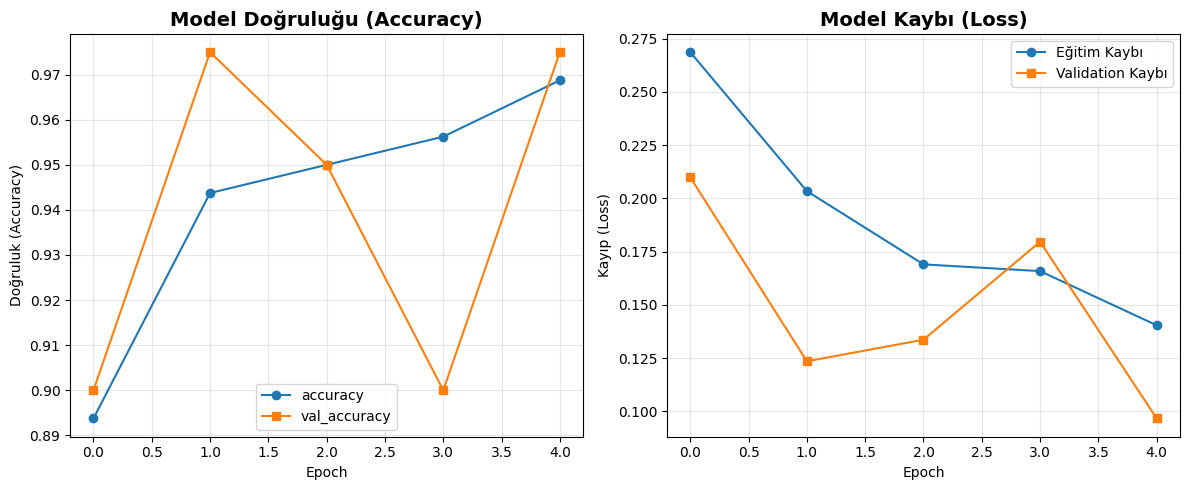

In [ ]:
# Grafik boyutunu ayarla
plt.figure(figsize=(12, 5))

# Doğruluk (Accuracy) Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='s')
plt.title('Model Doğruluğu (Accuracy)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (Accuracy)')
plt.legend()
plt.grid(True, alpha=0.3)

# Kayıp (Loss) Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı', marker='o')
plt.plot(history.history['val_loss'], label='Validation Kaybı', marker='s')
plt.title('Model Kaybı (Loss)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Grafik Yorumu:
# - Eğitim ve doğrulama eğrileri birbirine yakınsa model genelleme yapıyor demektir
# - Doğrulama accuracy'si eğitim accuracy'sinden çok düşükse overfitting var demektir
# - Loss değerleri azalıyorsa model öğreniyor demektir

# Test Verisi Üzerinde Final Değerlendirme

Bu aşamada, eğitilmiş olan modelin **hiç görmediği test verisi** üzerinde nasıl bir performans gösterdiğini ölçüyoruz.

## Değerlendirme Süreci:

`model.evaluate()` fonksiyonu:
- Modeli test verisiyle değerlendirir
- Hesaplanan kayıp (loss) ve doğruluk (accuracy) değerlerini döndürür
- Bu değerler, modelin gerçek dünya performansını gösterir



In [ ]:
# Modeli test verisi üzerinde değerlendir
loss, accuracy = model.evaluate(val_generator)
print(f"\n{'='*50}")
print(f"Model 1 (VGG16 Transfer Learning) Test Sonuçları:")
print(f"{'='*50}")
print(f"Test Doğruluğu (Accuracy): %{accuracy*100:.2f}")
print(f"Test Kaybı (Loss): {loss:.4f}")
print(f"{'='*50}")




2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9833 - loss: 0.0840 

Model 1 (VGG16 Transfer Learning) Test Sonuçları:
Test Doğruluğu (Accuracy): %97.50
Test Kaybı (Loss): 0.0967
